In [28]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

The code defines a set of classes that represent layers in a neural network. Each class has methods for forward propagation, backward propagation, and updating parameters.

1. Layer: This is the base class for all other layers. It includes methods for forward and backward propagation, as well as a method to update the layer’s parameters. The backward method calculates the gradient and updates the parameters accordingly. If the clip attribute is set to True, the gradients are clipped between -1e9 and 1e9 to prevent exploding gradients.

2. LinearLayer: This class inherits from the Layer class and represents a fully connected layer in a neural network. It initializes weight and bias parameters randomly. The forward method calculates the dot product of the input and the weights, adds the bias, and applies clipping if necessary. The update method adjusts the weights and biases based on the learning rate and the gradient.

3. ReLULayer: This class also inherits from the Layer class and implements the Rectified Linear Unit (ReLU) activation function. The forward method applies the ReLU function to the input, and the gradient method returns a binary mask indicating where the input was greater than 0.

4. LeakyReLULayer: This class is similar to the ReLULayer but implements the Leaky ReLU activation function, which allows a small gradient when the unit is not active.

5. PReLULayer: This class implements the Parametric ReLU activation function, which allows the negative slope to be learned. Unlike Leaky ReLU, the negative slope of the PReLU activation function is a learnable parameter.

In [29]:
class Layer:
    def __init__(self, clip=False) -> None:  # Constructor for the Layer class, initializes the clip attribute
        self.clip = clip  # If True, gradients will be clipped between -1e9 and 1e9
    def forward(self, x):  # Forward propagation method, to be implemented by subclasses
        pass
    def backward(self, next_gradient):  # Backward propagation method
        g = self.gradient()  # Calculate the gradient
        self.update(next_gradient)  # Update the parameters based on the gradient
        if g.shape == next_gradient.shape:  # If the shapes of the gradient and next_gradient match
            if self.clip:  # If clipping is enabled
                return np.clip(g * next_gradient, -1e9, 1e9)  # Return the clipped product of the gradient and next_gradient
            return g * next_gradient  # Otherwise, return the product of the gradient and next_gradient
        else:  # If the shapes of the gradient and next_gradient do not match
            z = np.dot(g, next_gradient)  # Calculate the dot product of the gradient and next_gradient
            if self.clip:  # If clipping is enabled
                return  np.clip(z, -1e9, 1e9)  # Return the clipped dot product
            return z  # Otherwise, return the dot product
    def update(self, next_gradient):  # Method to update the parameters, to be implemented by subclasses
        pass
    def gradient(self):  # Method to calculate the gradient, to be implemented by subclasses
        pass


class LinearLayer(Layer):  # LinearLayer class, inherits from the Layer class
    def __init__(self, in_feature, out_feature, lr=0.01, clip=False) -> None:  # Constructor for the LinearLayer class
        super().__init__(clip=clip)  # Call the constructor of the superclass
        self.shape = (out_feature, in_feature)  # Set the shape of the weight matrix
        self.W = np.random.uniform(-1, 1, self.shape)  # Initialize the weight matrix with random values
        self.B = np.random.uniform(-1, 1, (self.shape[0], 1))  # Initialize the bias vector with random values
        self.lr = lr  # Set the learning rate
        self.inputs = None  # Initialize the inputs attribute

    def forward(self, x):  # Forward propagation method
        if len(x.shape) < 2:  # If the input is a 1D array
            x = x.reshape(x.shape + (1,))  # Reshape it to a 2D array
        self.inputs = x  # Store the input
        z = np.dot(self.W, x) + self.B  # Calculate the output
        if self.clip:  # If clipping is enabled
            return np.clip(z, -1e9, 1e9)  # Return the clipped output
        return z  # Otherwise, return the output

    def update(self, next_gradient):  # Method to update the parameters
        self.W = self.W - self.lr * np.dot(next_gradient, self.inputs.T)  # Update the weights
        self.B = self.B - self.lr * next_gradient  # Update the biases

    def gradient(self):  # Method to calculate the gradient
        return self.W.T  # Return the transpose of the weight matrix


class ReLULayer(Layer):  # ReLULayer class, inherits from the Layer class
    def __init__(self, clip=False) -> None:  # Constructor for the ReLULayer class
        super().__init__(clip)  # Call the constructor of the superclass
    def forward(self, x):  # Forward propagation method
        self.inputs = x  # Store the input
        z = np.minimum(1e9, np.maximum(0, x))  # Apply the ReLU function to the input
        if self.clip:  # If clipping is enabled
            return np.clip(z, -1e9, 1e9)  # Return the clipped output
        return z  # Otherwise, return the output

    def gradient(self):  # Method to calculate the gradient
        g = np.where(self.inputs > 0, 1, 0)  # Calculate the gradient of the ReLU function
        return g  # Return the gradient


class LeakyReLULayer(Layer):  # LeakyReLULayer class, inherits from the Layer class
    def __init__(self, negative_slop=0.01, clip=False) -> None:  # Constructor for the LeakyReLULayer class
        super().__init__(clip=clip)  # Call the constructor of the superclass
        self.negative_slop = negative_slop  # Set the negative slope for the Leaky ReLU function
        self.inputs = None  # Initialize the inputs attribute

    def forward(self, x):  # Forward propagation method
        self.inputs = x  # Store the input
        f = np.maximum(0, x) + self.negative_slop * np.minimum(0, x)  # Apply the Leaky ReLU function to the input
        if self.clip:  # If clipping is enabled
            return np.clip(f, -1e9, 1e9)  # Return the clipped output
        return f  # Otherwise, return the output

    def gradient(self):  # Method to calculate the gradient
        g = np.where(self.inputs > 0, 1, self.negative_slop)  # Calculate the gradient of the Leaky ReLU function
        return g  # Return the gradient


class PReLULayer(Layer):  # PReLULayer class, inherits from the Layer class
    def __init__(self, out_feature, lr=0.001, clip=False) -> None:  # Constructor for the PReLULayer class
        super().__init__(clip=clip)  # Call the constructor of the superclass
        self.shape = (out_feature, 1)  # Set the shape of the parameter vector
        self.params = np.random.uniform(0, 1, self.shape)  # Initialize the parameter vector with random values
        self.lr = lr  # Set the learning rate
        self.inputs = None  # Initialize the inputs attribute

    def forward(self, x):  # Forward propagation method
        self.inputs = x  # Store the input
        f = np.maximum(0, x) + self.params * np.minimum(0, x)  # Apply the PReLU function to the input
        if self.clip:  # If clipping is enabled
            return np.clip(f, -1e9, 1e9)  # Return the clipped output
        return f  # Otherwise, return the output

    def update(self, next_gradient):  # Method to update the parameters
        mask = self.inputs < 0  # Create a mask where the input is less than 0
        self.params = self.params - self.lr * (mask * self.inputs) * next_gradient  # Update the parameters

    def gradient(self):  # Method to calculate the gradient
        ones = np.ones(self.shape)  # Create a matrix of ones with the same shape as the parameters
        zeros = np.zeros(self.shape)  # Create a matrix of zeros with the same shape as the parameters
        g = np.where(self.inputs > zeros, ones, self.params)  # Calculate the gradient of the PReLU function
        return g  # Return the gradient


The provided code defines a class `MSE` for the Mean Squared Error (MSE) loss function, which is commonly used in regression problems. Here's a summary:

1. `__init__(self, clip=False)`: This is the constructor method for the `MSE` class. It initializes an instance of the class and sets the `clip` attribute. If `clip` is set to `True`, the error will be clipped between `-1e9` and `1e9`.

2. `calculate(self, y, y_hat)`: This method calculates the MSE loss between the true values `y` and the predicted values `y_hat`. The loss is calculated as the mean of the squared differences between `y` and `y_hat`, divided by 2. If `clip` is `True`, the differences are clipped between `-1e9` and `1e9` before squaring.

3. `gradient(self, y, y_hat)`: This method calculates the gradient of the MSE loss with respect to the predicted values `y_hat`. The gradient is simply the difference between the predicted values `y_hat` and the true values `y`.

This class provides a simple and efficient way to calculate the MSE loss and its gradient, which are essential for training regression models using gradient-based optimization methods. The option to clip the error can be useful in scenarios where the error can become very large, which could lead to numerical instability.

In [30]:
class MSE:  # Define a class for Mean Squared Error (MSE) loss function
    def __init__(self, clip=False) -> None:  # Constructor for the MSE class, initializes the clip attribute
        self.clip = clip  # If True, the error will be clipped between -1e9 and 1e9

    def calculate(self, y, y_hat):  # Method to calculate the MSE loss
        z = y - y_hat  # Calculate the difference between the true values and the predicted values
        if self.clip:  # If clipping is enabled
            return np.mean(np.clip(z, -1e9, 1e9)**2) / 2  # Return the mean of the squared clipped differences divided by 2
        return np.mean(z**2) / 2  # Otherwise, return the mean of the squared differences divided by 2

    def gradient(self, y, y_hat):  # Method to calculate the gradient of the MSE loss
        return (y_hat-y)  # Return the difference between the predicted values and the true values


The provided code defines a class MLPModel for a Multilayer Perceptron (MLP), a type of feedforward artificial neural network. Here’s a summary:

1. __init__(self, loss, clip=False): This is the constructor method for the MLPModel class. It initializes an instance of the class, sets the clip attribute, and assigns the loss function.

2. add_layer(self, l): This method adds a layer to the neural network. The layer l is appended to the list of layers.

3. train(self, x, y, n_epochs, show=False): This method trains the model on the input data x with labels y for n_epochs epochs. For each epoch, it performs forward propagation through each layer, calculates the loss and its gradient, and performs backward propagation through each layer in reverse order. The method returns a list of the average loss for each epoch.

4. inference(self, x): This method performs inference on the input data x. It propagates the input through each layer of the network and returns the output.

In [31]:
class MLPModel:  # Define a class for a Multilayer Perceptron (MLP) model
    def __init__(self, loss, clip=False) -> None:  # Constructor for the MLPModel class
        self.layers = []  # Initialize an empty list to store the layers of the model
        self.clip = clip  # If True, gradients will be clipped between -1e9 and 1e9
        self.loss = loss(self.clip)  # Initialize the loss function for the model

    def add_layer(self, l):  # Method to add a layer to the model
        self.layers.append(l)  # Append the layer to the list of layers

    def train(self, x, y, n_epochs, show=False):  # Method to train the model
        losses = []  # Initialize an empty list to store the loss for each epoch
        for e in range(n_epochs):  # Loop over each epoch
            running_loss = 0  # Initialize a variable to store the running loss for each epoch
            for i, xi in enumerate(x):  # Loop over each sample in the input data
                for l in self.layers:  # Loop over each layer in the model
                    xi = l.forward(xi)  # Perform forward propagation through the layer
                grad = self.loss.gradient(y[i], xi)  # Calculate the gradient of the loss
                loss = self.loss.calculate(y[i], xi)  # Calculate the loss
                running_loss += loss  # Add the loss to the running loss
                for l in self.layers[::-1]:  # Loop over each layer in the model in reverse order
                    grad = l.backward(grad)  # Perform backward propagation through the layer
            losses.append(running_loss / len(x))  # Append the average loss for the epoch to the list of losses
            if show:  # If the show parameter is True
                print(f'{e}  loss: {losses[-1]}')  # Print the epoch number and the loss
        return losses  # Return the list of losses

    def inference(self, x):  # Method to perform inference with the model
        output = []  # Initialize an empty list to store the output
        for xi in x:  # Loop over each sample in the input data
            for l in self.layers:  # Loop over each layer in the model
                xi = l.forward(xi)  # Perform forward propagation through the layer
            output.append(xi)  # Append the output of the model to the list of outputs
        return np.array(output)  # Return the outputs as a numpy array


The provided code is creating an instance of the `MLPModel` with the Mean Squared Error (MSE) loss function and gradient clipping enabled. It then defines a list of layers for the model:

1. A `LinearLayer` that takes 1 input feature and outputs 32 features.
2. A `ReLULayer` which applies the Rectified Linear Unit (ReLU) activation function to its inputs.
3. Another `LinearLayer` that takes the 32 output features from the ReLU layer and outputs 1 feature.

These layers are then added to the model using the `add_layer` method. This setup is typical for a simple feed-forward neural network model used in regression tasks, where the goal is to predict a single continuous value (hence the final `LinearLayer` with 1 output feature). The use of the ReLU activation function allows the model to learn non-linear relationships in the data. The gradient clipping helps in stabilizing the training by limiting the values of gradients to the range `-1e9` to `1e9` to prevent the exploding gradient problem. This model is now ready to be trained using the `train` method of the `MLPModel` class.

In [32]:
model = MLPModel(MSE, True)  # Create an instance of the MLPModel class with MSE as the loss function and gradient clipping enabled
layers = [  # Define a list of layers for the model
    LinearLayer(1, 32),  # A LinearLayer that takes 1 input feature and outputs 32 features
    ReLULayer(),  # A ReLULayer which applies the Rectified Linear Unit (ReLU) activation function to its inputs
    LinearLayer(32, 1)  # Another LinearLayer that takes the 32 output features from the ReLU layer and outputs 1 feature
]

for l in layers:  # Loop over each layer in the list
    model.add_layer(l)  # Add the layer to the model


In [33]:
x_train = np.linspace(-4, 4, 2000).reshape(-1, 1, 1)  # Generate 2000 evenly spaced values between -4 and 4, and reshape them into a 3D array with shape (-1, 1, 1)
y_train = x_train ** 2  # Calculate the square of each value in x_train to create the y_train dataset
assert x_train[0] ** 2 == y_train[0]  # Assert that the first value in y_train is indeed the square of the first value in x_train
print(x_train[0], y_train[0])  # Print the first values of x_train and y_train


[[-4.]] [[16.]]


In [34]:
epochs = 100
hist = model.train(x_train, y_train, epochs, True)

0  loss: 0.16712997990778405
1  loss: 0.06176267667455405
2  loss: 0.12109848181082922
3  loss: 0.02486948874465661
4  loss: 0.010570017503734819
5  loss: 0.018351822836553063
6  loss: 0.010729812342550087
7  loss: 0.01175006009662997
8  loss: 0.013235802273878971
9  loss: 0.015819214557756495
10  loss: 0.016363960106294276
11  loss: 0.014890096100905853
12  loss: 0.014215502616227492
13  loss: 0.012517458512272851
14  loss: 0.011152660958108556
15  loss: 0.009748770975440524
16  loss: 0.008757292434478574
17  loss: 0.007848989388384839
18  loss: 0.00732286814569312
19  loss: 0.006920000095949516
20  loss: 0.006644718035489593
21  loss: 0.007138611437352459
22  loss: 0.007035505062778509
23  loss: 0.006673957575857286
24  loss: 0.006558852738628356
25  loss: 0.006805087722711457
26  loss: 0.0069655914656508045
27  loss: 0.00705774448347951
28  loss: 0.007317905381148071
29  loss: 0.007143764311006737
30  loss: 0.007051358955265522
31  loss: 0.007287958280589533
32  loss: 0.007006336334

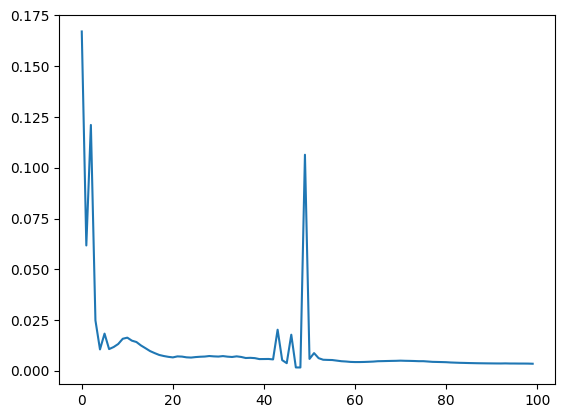

In [35]:
plt.plot(range(len(hist)), hist)

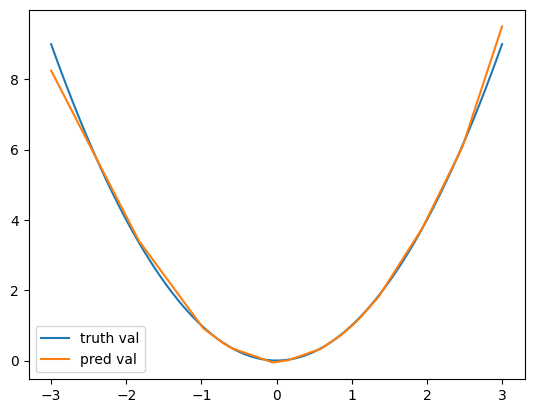

In [36]:
start = -3  # Define the start of the range for the test data
end = 3  # Define the end of the range for the test data
x_test = np.linspace(start, end, 1000).reshape(-1, 1, 1)  # Generate 1000 evenly spaced values between start and end, and reshape them into a 3D array with shape (-1, 1, 1)
y_test = (x_test ** 2).reshape(-1, 1)  # Calculate the square of each value in x_test to create the y_test dataset and reshape it into a 2D array with shape (-1, 1)
y_pred = model.inference(x_test).reshape(-1, 1)  # Use the model to predict the output for the test data and reshape the output into a 2D array with shape (-1, 1)

plt.plot(x_test.reshape(-1, 1), y_test, label='truth val')  # Plot the true values of the test data
plt.legend()  # Add a legend to the plot
plt.plot(x_test.reshape(-1, 1), y_pred, label='pred val')  # Plot the predicted values of the test data
plt.legend()  # Add a legend to the plot
